Using sdpa and add optimizer and compile and more data

# Tiny Stories Hackathon
> From Cluster of stars study group

## Data

### Dataset 

In [ ]:
from datasets import load_dataset
import tiktoken
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor, BoolTensor

from minai import *

Grab tiny stories data from hugging face.

In [ ]:
ds = load_dataset('roneneldan/TinyStories')
trn = ds['train']
val = ds['validation']
trn

Dataset({
    features: ['text'],
    num_rows: 2119719
})

In [ ]:
val

Dataset({
    features: ['text'],
    num_rows: 21990
})

In [ ]:
tokenizer = tiktoken.get_encoding('gpt2')

txt = trn[0]['text']
txt

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'

In [ ]:
def txt_to_toks(txt, toker): return toker.encode(txt)

In [ ]:
def toks_to_txt(toks, toker): return toker.decode(toks)

In [ ]:
1024

1024

In [ ]:
separator="<|endoftext|>"
ctx_len = 1024
num_txts = 21197

trn_txts = separator.join([trn[i]['text'] for i in range(num_txts)])
trn_txts[:1000]

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.<|endoftext|>Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leaves 

We create a dataset.

In [ ]:
# Code from llm from scratch
class TinyDataset(Dataset):
    def __init__(self, txt, tokenizer, ctx_len):
        self.inp = []
        self.targ = []
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        for i in range(0, len(token_ids) - ctx_len, ctx_len):
            inp_chunk = token_ids[i:i + ctx_len]
            targ_chunk = token_ids[i + 1: i + ctx_len + 1]
            self.inp.append(torch.tensor(inp_chunk))
            self.targ.append(torch.tensor(targ_chunk))

    def __len__(self): return len(self.inp)

    def __getitem__(self, idx): return self.inp[idx], self.targ[idx]

In [ ]:
trn_ds = TinyDataset(trn_txts, tokenizer, ctx_len)
trn_ds[0]

(tensor([ 3198,  1110,    11,  ..., 24829,   284,   262]),
 tensor([1110,   11,  257,  ...,  284,  262, 7586]))

In [ ]:
## Validation set
num_val_txts = 21990
val_txts = separator.join([val[i]['text'] for i in range(num_val_txts)])
val_ds = TinyDataset(val_txts, tokenizer, ctx_len)

### DataLoader

In [ ]:
bs = 3

trn_dl, val_dl = get_dls(trn_ds, val_ds, bs, drop_last=True)
dls = DataLoaders(trn_dl, val_dl)
xb,yb = next(iter(trn_dl))
xb.shape,yb.shape

(torch.Size([3, 1024]), torch.Size([3, 1024]))

## Model

### SDPA

In [ ]:
import torch.nn as nn

Here's the `MultiHeadAttention` with Causal attention.

In [ ]:
class SDPACausalAttentionBlock(nn.Module):
    """
    Attention block implementing multi-head causal (masked) attention using
    PyTorch's scaled_dot_product_attention (SDPA).
    """

    def __init__(
        self,
        hidden_dim: int,
        num_heads: int,
        dropout: float = 0.0,
    ):
        """
        Initialize the causal attention block with SDPA implementation.

        Args:
            hidden_dim: Dimension of the input and output features
            num_heads: Number of attention heads
            dropout: Output dropout probability (0.0 means no dropout)

        Note:
            - Make sure to check that hidden_dim is divisible by num_heads
            - You'll need to create linear (projection) layers for query, key, and value
            - Don't forget the output linear (projection) layer
            - Create an output dropout layer
        """
        super().__init__()
        if hidden_dim % num_heads != 0: raise Exception("hidden_dim not divisible by num_heads")
        self.head_dim = hidden_dim // num_heads
        self.num_heads = num_heads
        self.Wq, self.Wk, self.Wv = nn.Linear(hidden_dim, hidden_dim), nn.Linear(hidden_dim, hidden_dim), nn.Linear(hidden_dim, hidden_dim)
#         self.Wo = nn.Linear(hidden_dim, hidden_dim)
#         self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass.

        Args:
            x: Input tensor of shape [batch_size, seq_len, hidden_dim].

        Returns:
            Tensor of shape [batch_size, seq_len, hidden_dim] after attention.
        """
        batch_size, seq_len, hidden_dim = x.shape
        q,k,v = self.Wq(x), self.Wk(x), self.Wv(x) # [batch_size, seq_len, d_out]

        sdpa_ctx = torch.nn.functional.scaled_dot_product_attention(
            q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2), 
            k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2), 
            v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2), 
            dropout_p=0.0, is_causal=True, scale=None)
        sdpa_ctx = sdpa_ctx.transpose(1,2).view(batch_size, seq_len, -1)
#         return self.dropout(self.Wo(sdpa_ctx))
        return sdpa_ctx

### FeedForward

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, in_dim, hidden_dim, act=nn.ReLU()):
        super().__init__()
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.act = act
        self.l2 = nn.Linear(hidden_dim, in_dim)
    
    def forward(self, x):
        return self.l2(self.act(self.l1(x)))

### Transformer Block

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim, ctx_len, n_head, drop_out=0, ff_mult=4, qkv_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ln2 = nn.LayerNorm(emb_dim)
        self.mha = SDPACausalAttentionBlock(hidden_dim=emb_dim, num_heads=n_head, dropout=drop_out)
#         self.do = nn.Dropout(drop_out)
        self.ff = FeedForward(emb_dim, emb_dim*ff_mult)
    
    def forward(self, x):
        skip1 = x
        x = self.ln1(x)
        x = self.mha(x)
#         x = self.do(x)
        x = x + skip1
        
        skip2 = x
        x = self.ln2(x)
        x = self.ff(x)
#         x = self.do(x)
        x = x + skip2
        return x

### GPT model

In [ ]:
cfg = {
    'n_tb': 1,    # num transformer blocks
    'vocab_sz': 50257,
    'emb_dim': 48,
    'ctx_len': ctx_len,
    'n_head': 1,
    'drop_out': 0,
    'drop_out_tb': 0,  # dropout within transformer blocks
    'ff_mult': 4,
    'qkv_bias': False,
     }

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg['vocab_sz'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['vocab_sz'], cfg['emb_dim'])
        self.do = nn.Dropout(cfg['drop_out'])
        self.tb = nn.Sequential(
            *[TransformerBlock(cfg['emb_dim'], cfg['ctx_len'], cfg['n_head'], cfg['drop_out_tb'],
                              cfg['ff_mult'], cfg['qkv_bias']) for _ in range(cfg['n_tb'])])
        self.final_ln = nn.LayerNorm(cfg['emb_dim'])
        self.final_l  = nn.Linear(cfg['emb_dim'], cfg['vocab_sz'])
    
    def forward(self, x):
        bs, seq_len = x.shape
        tok = self.token_emb(x)
        pos = self.pos_emb(torch.arange(seq_len, device=x.device))
        x = self.do(tok + pos)
        x = self.tb(x)
        x = self.final_ln(x)
        x = self.final_l(x)
        return x

In [ ]:
batch = xb[:3]
batch.shape

torch.Size([3, 1024])

In [ ]:
set_seed(42)
model = GPTModel(cfg)
logits = model(batch)
logits.shape

torch.Size([3, 1024, 50257])

In [ ]:
def get_total_params(model): return sum(p.numel() for p in model.parameters())
total_params = get_total_params(model)

In [ ]:
model.token_emb.weight.shape, model.final_l.weight.shape

(torch.Size([50257, 48]), torch.Size([50257, 48]))

In [ ]:
def get_total_memory(model):
    total_params = get_total_params(model)
    total_size_bytes = total_params * 4   # Assuming fp32
    # Convert to megabytes
    total_size_mb = total_size_bytes / (1024 * 1024)
    print(f"Total params: {total_params:,}")
    print(f"Total size: {total_size_mb:.2f} MB")

get_total_memory(model)

Total params: 7,313,281
Total size: 27.90 MB


### Text generation

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Crop current context if it exceeds the supported context size
        with torch.no_grad(): logits = model(idx_cond)         # (bs, n_tokens, vocab_sz)
        logits = logits[:, -1, :]                              # (bs, vocab_sz)
        probas = torch.softmax(logits, dim=-1)                 # (bs, vocab_sz)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (bs, 1)
        idx = torch.cat((idx, idx_next), dim=1)                # (bs, n_tokens+1)
    return idx

In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

In [ ]:
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

## Learner

In [ ]:
from torcheval.metrics import  MulticlassAccuracy

In [ ]:
def loss_fn(pred, targ): return F.cross_entropy(pred.flatten(0, 1), targ.flatten())

In [ ]:
cfg = {
    'n_tb': 12,    # num transformer blocks
    'vocab_sz': 50257,
    'emb_dim': 768,
    'ctx_len': ctx_len,
    'n_head': 12,
    'drop_out': 0,
    'drop_out_tb': 0,  # dropout within transformer blocks
    'ff_mult': 4,
    'qkv_bias': False,
}

In [ ]:
torch.set_float32_matmul_precision('high')

In [ ]:
model = torch.compile(GPTModel(cfg).to(def_device), mode="reduce-overhead")

In [ ]:
class LLMMetricsCB(MetricsCB):
    def __init__(self, *ms, **metrics):
        super().__init__(*ms, **metrics)
    
    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds.flatten(0, 1)), y.flatten())
        self.loss.update(to_cpu(learn.loss), weight=len(x))

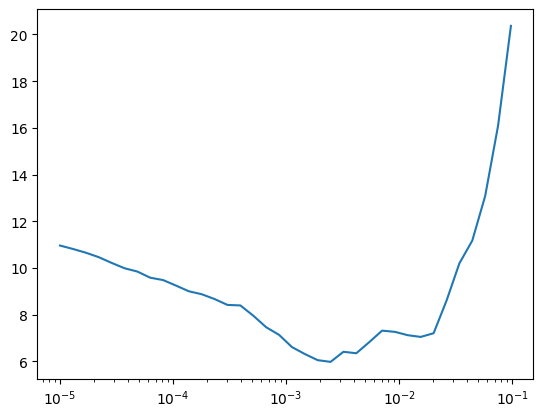

In [ ]:
opt = torch.optim.AdamW
cbs = [LLMMetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(), TrainCB(), DeviceCB()]
learn = Learner(model, dls, loss_func=loss_fn, cbs=cbs, opt_func=opt)
learn.lr_find()

accuracy,loss,epoch,train,time
0.258,4.098,0,train,13:36
0.302,3.598,0,eval,10:17


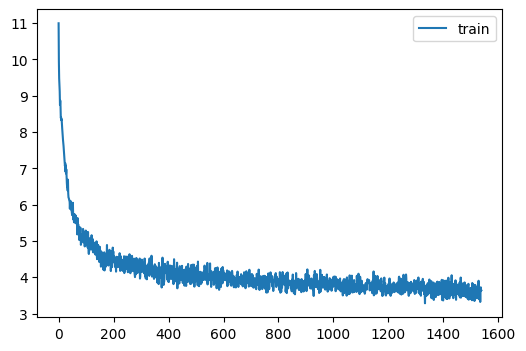

In [ ]:
set_seed(42)
model = torch.compile(GPTModel(cfg).to(def_device), mode="reduce-overhead")
cbs = [LLMMetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True), TrainCB(), DeviceCB()]
learn = Learner(model, dls, loss_func=loss_fn, cbs=cbs, opt_func=opt)
learn.fit(1, lr=1e-4)

In [ ]:
start_context = "Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could"
model.eval()
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer).to(def_device),
    max_new_tokens=100,
    context_size=cfg["ctx_len"])

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could not to the park.

One day, she was so happy that she was so happy that she had been so happy that she had never seen.

The little girl was so excited to the park. She was so happy that she had never seen. She was so happy that she had been so happy that she had never seen.

The little girl was so happy that she was so happy that she had been so happy that she had been so happy that she was so happy that


Hyperparameters: Learning rate, optimizer: Gradient clipping, batch size: 4k

Mixed precision -> weight decay needed. (bfloat16)

Distributed data parallel: Split data into 2 and use graident accumulation

Fully Sharded data parallel: shard of data into GPUs as layer goes.

CPU offload

DataLoader: Use for loop.

!!!!! Look at the data. !!!!!

Eval: next token accuracy, loss

Try GLU instead of ReLU

Tips: 

1. Try simple model.
2. Weight Tying.
3. Hyperparameter sweep
4. minbpe


Get sequencing packing to work -> iterate faster
flash attention.

Use triton cross entropy loss or compile nn.crosstropyloss

Add view(-1,...) before flash attention and remove view(-1,...)